<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Projects/Food_Recognition_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Recognition / Segmentation 

Link for the competition : https://www.aicrowd.com/challenges/food-recognition-challenge

So this is an dataset from AICrowd’s closed competition, since I have worked with a lot of Image Classification problem now I think it’s time for me to tackle a different problem other than segmentation. 

**So the two main challenge is I am going to use TensorFlow to build this project and deploy once it’s done.** 

I am planning to spend 1-2 hours everyday on this and no worries even if it takes a month to finish. Can’t wait to learn what’s in this and this could be one of my biggest milestone project if I get this done. 

In [1]:
!nvidia-smi

Wed Jun  9 12:28:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
 # Importing my drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Getting our paths (train and validation)
train_gz = 'drive/MyDrive/data/train-v0.4.tar.gz'
#val_gz = 'drive/MyDrive/data/val-v0.4.tar.gz' can't open this file 

# And thank goodness the val images and annot is in the train_gz file itself.

In [5]:
# Extracting all the files inside our tar file 
import tarfile 
file = tarfile.open(train_gz)
file.extractall('fine_data/')

In [6]:
# Getting the paths of image and the annotations seperate 

train_images = 'fine_data/train/images'
train_annot = 'fine_data/train/annotations.json'
val_images = 'fine_data/val/images'
val_annot = 'fine_data/val/annotations.json'

## Become one with the image data 

In [7]:
# How many images are there in our train and val folder? 
import os
num_train_imgs = len(os.listdir(train_images))
num_val_imgs = len(os.listdir(val_images))

print(f'Number of images in the training folder: {num_train_imgs}')
print(f'Number of images in the validation folder: {num_val_imgs}')

Number of images in the training folder: 24119
Number of images in the validation folder: 1269


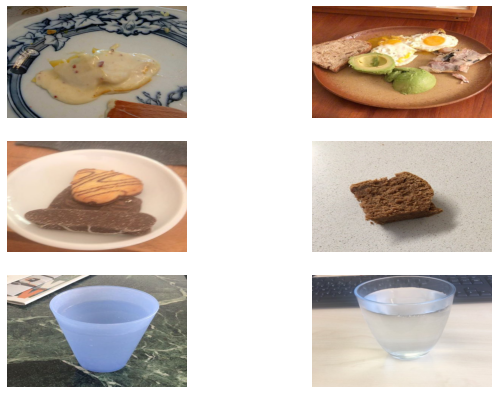

In [8]:
# Creating a function that will help us to visualize random images from train / validation set
import random
from PIL import Image

def plot_random_images(columns , rows , img_width , img_height , folder):
  fig = plt.figure(figsize = (10 , 7))
  for i in range(1 , columns*rows + 1):
    img_file = random.choice(os.listdir(folder))
    img = Image.open(folder + '/' + img_file)
    img = img.resize((img_width , img_height) , Image.ANTIALIAS)
    fig.add_subplot(rows , columns , i)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

# Using the function
plot_random_images(2 , 3 , img_width= 400, img_height= 250 , 
                   folder = train_images)

Alright we have visualized our data, now it's time to unravel the annotations file and see if we can mask it on our image and visualize it. I haven't worked with json before so this is going to be new and exciting! 

In [9]:
# Importing the needed library 
import json 

# Opening the json file 
train_file = open(train_annot)

# Returning a JSON object as a dictionary 
dict_annot = json.load(train_file)

dict_annot.keys()

dict_keys(['categories', 'info', 'images', 'annotations'])

In [10]:
one_annot_sample = dict_annot['annotations'][:1]
one_annot_sample

[{'area': 44320.0,
  'bbox': [86.5, 127.49999999999999, 286.0, 170.0],
  'category_id': 2578,
  'id': 102434,
  'image_id': 65537,
  'iscrowd': 0,
  'segmentation': [[235.99999999999997,
    372.5,
    169.0,
    372.5,
    163.0,
    370.5,
    155.5,
    360.0,
    140.5,
    295.0,
    127.49999999999999,
    172.0,
    128.5,
    110.0,
    134.5,
    97.0,
    141.0,
    92.5,
    173.0,
    86.5,
    240.00000000000003,
    83.5,
    266.0,
    86.5,
    284.0,
    92.5,
    290.5,
    99.0,
    297.5,
    138.0,
    297.5,
    232.0,
    284.5,
    341.0,
    277.5,
    363.0,
    273.0,
    368.5,
    264.0,
    371.5]]}]

In [12]:
# Indexing inside and looking at each values
print(f"Bbox value: {one_annot_sample[0]['bbox'] }")
print(f"Image ID: {one_annot_sample[0]['image_id']}")
print(f"Segemntation value: {one_annot_sample[0]['segmentation']}")

Bbox value: [86.5, 127.49999999999999, 286.0, 170.0]
Image ID: 65537
Segemntation value: [[235.99999999999997, 372.5, 169.0, 372.5, 163.0, 370.5, 155.5, 360.0, 140.5, 295.0, 127.49999999999999, 172.0, 128.5, 110.0, 134.5, 97.0, 141.0, 92.5, 173.0, 86.5, 240.00000000000003, 83.5, 266.0, 86.5, 284.0, 92.5, 290.5, 99.0, 297.5, 138.0, 297.5, 232.0, 284.5, 341.0, 277.5, 363.0, 273.0, 368.5, 264.0, 371.5]]


Since my annotations is in the COCO format I have to find a way to parse the bbox and segmentations files and annotate my images. Not really sure how it works, will come back tomorrow and see if I can pull any strings. 


### Things to do: 
- [x] Download the data from AICrowd database 
- [x] Write a script to untar the data because it’s in the tar.gz format. I did tried using `tf.keras.utils.get_files`  but the problem is I can’t find the root path.  
- [x] Visualise and become one with the image data 
- [x] Dig deep into the annotation file and see what’s in there.
- [ ] Find a way to annotate the image 
- [ ] Plot random images with annotations 

Will continue tomorrow! 




In [23]:
dict_annot['annotations'][1]['segmentation']

[[254.99999999999997,
  411.5,
  223.0,
  410.5,
  200.0,
  402.5,
  178.0,
  399.5,
  153.5,
  384.0,
  143.5,
  371.0,
  135.5,
  351.0,
  132.5,
  306.0,
  126.49999999999999,
  282.0,
  127.49999999999999,
  258.0,
  134.5,
  240.00000000000003,
  164.5,
  199.0,
  180.5,
  167.0,
  183.5,
  152.0,
  190.5,
  138.0,
  213.0,
  111.5,
  242.99999999999997,
  95.5,
  256.0,
  95.5,
  275.0,
  100.5,
  289.5,
  113.0,
  297.5,
  127.0,
  301.5,
  181.0,
  308.5,
  213.0,
  330.5,
  266.0,
  339.5,
  304.0,
  338.5,
  337.0,
  330.5,
  358.0,
  307.0,
  377.5,
  290.0,
  398.5,
  272.0,
  408.5]]

In [24]:
!pip install pycoco

     |████████████████████████████████| 737kB 13.2MB/s 
     |████████████████████████████████| 409kB 35.3MB/s 
  Created wheel for pycoco: filename=pycoco-0.7.2-cp37-none-any.whl size=9791 sha256=04d589c2f8d858e9ea68fa261938184162bf3134968b5e271804fabad450a292
  Stored in directory: /root/.cache/pip/wheels/d5/9f/9c/6f40b261f0abad9f29cfe967547d036e4bcfa6a225e442a678
  Created wheel for ll-xist: filename=ll_xist-5.65-cp37-cp37m-linux_x86_64.whl size=635987 sha256=c60f2f5b0f6468746f0fbe5816afdd067b5b647c3842819709103d8c76b09d76
  Stored in directory: /root/.cache/pip/wheels/87/0b/ed/f5cc37aaddb7e4468737921ddf47bf8b96ad4543ceefdcbfd7
Successfully built pycoco ll-xist
